
This tutorial introduces PyTorch and how to use pre-trained models for image classification. Pre-trained models offer excellent performance with minimal effort, as they have already learned visual features from large datasets.


Here use a ResNet-50 model pre-trained on ImageNet and fine-tune that model on the MiniPlaces dataset.




# 👨🏽‍🔧 Setting up the Environment


In [1]:
import torch
import torchvision
from torchvision import transforms, datasets

# ⬇️ Download and Prepare the Dataset

In typical image classification datasets, the folder structure is usually organized in a way that each class of images is stored in its own sub-folder.

This is commonly referred to as the "Image Folder" structure.

When downloaded and extracted the MiniPlaces dataset,  find the images organized into folders according to their respective classes.

Image folder format looks like this:

```
miniplaces/
|-- train/
|   |-- class1/
|   |   |-- image1.jpg
|   |   |-- image2.jpg
|   |   |-- ...
|   |-- class2/
|   |   |-- image1.jpg
|   |   |-- image2.jpg
|   |   |-- ...
|   |-- ...
|-- val/
|   |-- class1/
|   |   |-- image1.jpg
|   |   |-- image2.jpg
|   |   |-- ...
|   |-- class2/
|   |   |-- image1.jpg
|   |   |-- image2.jpg
|   |   |-- ...
|   |-- ...
```

### 🪜 The following code performs several steps:

1. **Download and Extract Dataset:** Downloads the MiniPlaces dataset and extracts it to the 'datasets' directory.

2. **Setup Paths:** Sets up paths for the main dataset, the validation set, and creates a new directory for the test set.

3. **List Classes:** Lists all the classes in the dataset by iterating over the directories in the validation set.

4. **Split Validation Set:** For each class, splits the images in the validation set into a smaller validation set and a new test set using a 60/40 split.

5. **Move Images:** Moves the images for the test set from the validation directory to the test directory, maintaining the original directory structure.

In [2]:
%%capture
!wget https://dissect.csail.mit.edu/datasets/miniplaces.zip --no-check-certificate && unzip miniplaces.zip

In [3]:
from pathlib import Path
from sklearn.model_selection import train_test_split
import shutil

# set the dataset path
dataset_path = Path('miniplaces')
val_path = dataset_path / 'val'

# get the list of classes
classes = [d.name for d in val_path.iterdir() if d.is_dir()]

# create a test directory
test_path = dataset_path / 'test'
test_path.mkdir(exist_ok=True)

# iterate over each class
for class_name in classes:
    class_dir = val_path / class_name
    class_files = [f.name for f in class_dir.iterdir() if f.is_file()]

    # split the validation set
    val_files, test_files = train_test_split(class_files, test_size=0.4, random_state=42)

    # create new test class directory
    test_class_dir = test_path / class_name
    test_class_dir.mkdir(exist_ok=True)

    # move test files from validation folder to test folder
    for test_file in test_files:
        source = class_dir / test_file
        destination = test_class_dir / test_file
        shutil.move(source, destination)

### 💾 Dataset and Dataloader
In PyTorch, datasets and dataloaders are essential components for efficiently working with large-scale datasets during the training process.

1) **Dataset**: A Dataset in PyTorch represents a collection of data. It could be in-memory data like a list of Python objects or out-of-memory data like images on a disk. The Dataset class provides a standardized way to access this data. You typically subclass the Dataset class and implement the `__getitem__` and `__len__` methods to return a single data item and the size of the dataset, respectively. PyTorch also provides several pre-defined Dataset classes like ImageFolder for common use-cases.

2) **DataLoader**: While the Dataset class provides a way to access individual data items, the DataLoader class provides a way to iterate over a Dataset in batches. This is important because when training a neural network, you typically don't feed in the entire dataset at once but process it in smaller batches. The DataLoader also makes it easy to shuffle the data and use multiple subprocesses to load the data in parallel.

To create datasets and dataloaders for the MiniPlaces dataset, you can use PyTorch's `ImageFolder` and `DataLoader` classes.

The `ImageFolder` class allows you to load the images directly from the directory structure, and the `DataLoader` class provides an efficient way to iterate over these images during training.

The following code will set up the datasets, dataloaders, and basic transforms. Here's what is happening:

 - The `transforms.Compose` function is used to combine a series of image transformations that will be applied to the images. Here's a breakdown of the tranforms:
   - **Resize to 256x256**: Resize images to 256 pixels for consistency, as the final size needed is 224x224 pixels.
   - **Random Crops of 224x224**: To prepare the image for ResNet-50 and provide data augmentation, you will randomly crop a 224x224 patch from the original 256x256 image after resizing. This will result in variations of the same image, which can enhance the model's robustness and prevent overfitting.
   - By randomly cropping different 224x224 patches from the original 256x256 image, you're essentially creating slightly different variations of the same image.
   - Converted to PyTorch tensors
   - The normalization values (`[0.485, 0.456, 0.406]` for the means and `[0.229, 0.224, 0.225]` for the standard deviations) are the standard normalization parameters for ImageNet data, which is the dataset that the pre-trained ResNet model was trained on.
    - Normalizing data is important in deep learning to adjust pixel intensity values to a standardized range, improving model performance and maximizing the usefulness of pre-trained weights. This involves using mean and standard deviation values from the ImageNet dataset to normalize pixel values in other images, ensuring they are on a similar scale and avoiding suboptimal performance due to features with larger scales.

 - The `ImageFolder` class is used to create datasets for the train, validation, and test sets.

 - The `DataLoader` class is used to create dataloaders for the datasets. The `batch_size` is set to 64, and `shuffle=True` for the training set to ensure that the training samples are shuffled before each epoch. For the validation and test sets, `shuffle=False` since the order of these samples does not matter.

In [4]:
import torch
from torchvision import datasets, transforms

# define the transform
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # resize images to 256x256
    transforms.RandomCrop((224, 224)),  # random crop images to 224x224
    transforms.ToTensor(),  # convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalize images to ImageNet mean and sd
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize images to 224x224
    transforms.ToTensor(),  # convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalize images to ImageNet mean and sd
])

# define the datasets
train_dataset = datasets.ImageFolder(dataset_path / 'train', transform=train_transform)
val_dataset = datasets.ImageFolder(dataset_path / 'val', transform=test_transform)
test_dataset = datasets.ImageFolder(dataset_path / 'test', transform=test_transform)

# define the dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

inspect class names like so, note this only shows the first 10 classes.

In [5]:
train_dataset.classes[:10]

['abbey',
 'airport_terminal',
 'amphitheater',
 'amusement_park',
 'aquarium',
 'aqueduct',
 'art_gallery',
 'assembly_line',
 'auditorium',
 'badlands']

And see the number of classes like so:

In [6]:
n_classes = len(train_dataset.classes)
print(n_classes)

100


# Instantiate a Pretrained Model

###  Pretrained Models

Pretrained models are models that are already trained on large image datasets.

They can extract important features for computer vision tasks like image classification. These models save time and resources and have better performance than training a model from scratch.

can access them in PyTorch using `torchvision.models`.

Here's how to instantiate a ResNet-50 model thats been pre-trained on ImageNet:

In [7]:
from torchvision.models import resnet50, ResNet50_Weights

# Fetch the pretrained ResNet-50 model
model = resnet50(weights=ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 198MB/s]


successfully fetched a pre-trained ResNet-50 model!

However, this model is trained on the ImageNet dataset, which has 1000 classes. need to modify the model to work with the MiniPlaces dataset, which has 100 classes.

The part of the model that need to modify is the last fully connected layer (`fc`).

This layer is responsible for producing the final output classes from the features extracted by the rest of the network. By modifying the final fully connected layer, can fine-tune the pretrained model to classify images into the desired number of classes.

Here's how can modify the last fully connected layer to output 100 classes, note you're using `n_classes` because defined this earlier:


In [8]:
import torch.nn as nn

# Fetch the pretrained ResNet-50 model
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# Modify the last layer
num_ftrs = model.fc.in_features  # get the number of input features for the last layer
model.fc = nn.Linear(num_ftrs, n_classes)  # create a new layer with the same number of input features and 100 output features

# 📉 Defining the Loss Function and Optimizer

### Loss Function

In PyTorch, various loss functions are available for different types of tasks.

For multiclass classification tasks, a commonly used loss function is `nn.CrossEntropyLoss`.

This loss function combines the softmax activation and the negative log likelihood loss, making it suitable for training models to predict class probabilities.

To instantiate a `nn.CrossEntropyLoss` object, can use the following code:

In [9]:
import torch.nn as nn

# Instantiate the CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# 🏋🏾 Optimizer

 Optimizers responsible for updating the model's parameters based on the computed gradients during the backward pass.

 PyTorch provides various optimizers, such as `torch.optim.SGD`, `torch.optim.Adam`, and more.


Adam is an adaptive learning rate optimization algorithm that computes individual adaptive learning rates for different parameters. It combines the advantages of both AdaGrad and RMSProp optimizers.

instantiate an Adam optimizer named optimizer by passing the model's parameters (`model.parameters()`) to optimize and specifying the learning rate (`lr`) and weight decay (`weight_decay`) as arguments:

In [10]:
import torch.optim as optim

# Set the learning rate and weight decay
learning_rate = 0.001
weight_decay = 0.0001

# Instantiate the Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# 🔄 Training Loop

The training loop involves several steps: forward pass, loss calculation, backward pass, parameter updates, and optional validation.

need to set up a training loop that goes through your training data in epochs (an epoch is one full pass through the entire training dataset).

In each epoch, go through each batch of training data, use model to generate predictions, calculate the loss with loss function, and then use optimizer to perform backpropagation and update the model's weights.

###🎚️ Train and Eval Mode

Before training your model, put it in training mode. This is done by calling `model.train()`.

In training mode, certain layers of your model, such as Dropout and BatchNorm, behave differently than in evaluation mode.

When evaluating your model, such as on a validation dataset or test dataset, switch it to evaluation mode by calling `model.eval()`.

In evaluation mode, the Dropout layers don't drop out nodes and BatchNorm uses the running estimates instead of batch statistics.


### 💻 Device Config

In the code below, first check if a GPU is available using `torch.cuda.is_available()`.

If it is, assign the device as "cuda", indicating that want to use the GPU. Otherwise, assign the device as "cpu".

then move the model to the selected device using the `to()` method.

# What just happened?

In the code above, first set the number of training epochs using the `num_epochs` variable.

then iterate over each epoch.

Inside the epoch loop, you initialize the metrics `total_loss`, `correct`, and `total` to keep track of the loss and accuracy during training.

set the model to training mode using `model.train()`.

Next, iterate over the training dataloader, which provides batches of images and labels.

move the images and labels to the selected device using `to(device)`. You zero the gradients using `optimizer.zero_grad()` to avoid accumulating gradients from previous iterations.

then perform the forward pass by passing the images through the model (`model(images)`). calculate the loss between the predicted outputs and the ground truth labels using the loss function (`criterion(outputs, labels)`).

After the forward pass, perform the backward pass using `loss.backward()` to compute the gradients of the model's parameters. You update the parameters using `optimizer.step()`.

During the iteration, update the training metrics, including the total loss, the number of correctly predicted samples (`correct`), and the total number of samples (`total`).

At the end of each epoch, calculate the average training loss and accuracy.

then print these metrics to monitor the training progress.

In [11]:
# check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# move the model to the GPU
model = model.to(device)

# Set the number of training epochs
num_epochs = 2

# Initialize lists for storing training metrics
train_losses = []
train_accuracies = []

# in your training loop, move your data to the GPU before feeding it into your model
for epoch in range(num_epochs):
    # Initialize metrics
    total_loss = 0.0
    correct = 0
    total = 0

    # Set the model to training mode
    model.train()

    # Iterate over the training dataset
    for images, labels in train_loader:
        # Move images and labels to the appropriate device
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Parameter updates
        optimizer.step()

        # Update metrics
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Calculate average training loss and accuracy
    average_loss = total_loss / len(train_loader)
    accuracy = 100.0 * correct / total

    # Log training metrics
    train_losses.append(average_loss)
    train_accuracies.append(accuracy)

    # Print training metrics for the current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy:.2f}%")

Epoch [1/2], Loss: 2.3648, Accuracy: 38.52%
Epoch [2/2], Loss: 1.9405, Accuracy: 47.79%


# Training Visualization

Here are the steps to log and visualize training metrics in your code:

- Initialize empty lists to store training loss and accuracy for each epoch
- Calculate the average training loss and accuracy during each epoch and append these values to the respective lists
- Once the training loop ends, plot the training metrics using matplotlib by creating a figure with two subplots, one for training loss and one for training accuracy
- Plot the respective lists against the epochs using `plt.plot()`
- Set the labels and titles for the plots
- Show the figure using `plt.show()`


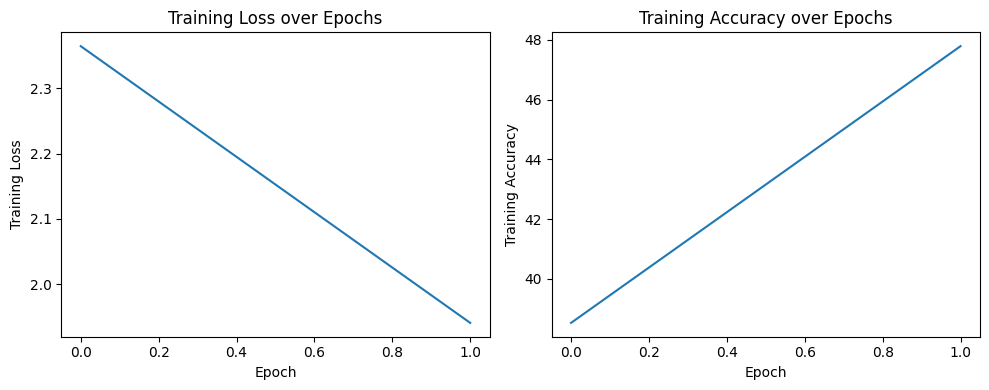

In [12]:
import matplotlib.pyplot as plt

# Plot training metrics
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss over Epochs")
plt.subplot(1, 2, 2)
plt.plot(train_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy over Epochs")
plt.tight_layout()
plt.show()

# Testing and Evaluation:

### Model Evaluation

Metrics like accuracy, precision, and recall can reveal its classification ability.

In the code below does the following:
- Input trained model and test dataloader to `evaluate_model` function
- Set model to evaluation mode using model.`eval()`
- Initialize variables to track sample numbers, correct and predicted positives, and actual positives
- Iterate through test dataloader to perform inference
- Update variables to calculate evaluation metrics such as accuracy, precision, and recall

In [13]:
def evaluate_model(model, dataloader):
    model.eval()  # Switch the model to evaluation mode

    # Initialize counters
    total = 0
    correct = 0
    true_positives = 0
    predicted_positives = 0
    actual_positives = 0

    with torch.no_grad():  # No need to calculate gradients for evaluation
        for images, labels in dataloader:
            images = images.to(device)  # Move images to the device
            labels = labels.to(device)  # Move labels to the device

            outputs = model(images)  # Get model outputs
            _, predicted = outputs.max(1)  # Get predicted classes

            # Update counters
            total += labels.size(0)  # Total number of samples
            correct += predicted.eq(labels).sum().item()  # Total number of correct predictions

            # Count the true positives, predicted positives, and actual positives
            true_positives += torch.logical_and(predicted == 1, labels == 1).sum().item()
            predicted_positives += (predicted == 1).sum().item()
            actual_positives += (labels == 1).sum().item()

    # Calculate metrics
    accuracy = 100.0 * correct / total  # Accuracy = correct / total
    precision = true_positives / predicted_positives  # Precision = TP / (TP + FP)
    recall = true_positives / actual_positives  # Recall = TP / (TP + FN)

    return accuracy, precision, recall


test_accuracy, test_precision, test_recall = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")


Test Accuracy: 43.65%
Test Precision: 0.19
Test Recall: 0.72


#  Inference

After training and evaluating the model, use it to make predictions on new, unseen images.

The following code will:

- Load a new image saved at the specified path.
- Use PIL to load the image.
- Convert the image to the RGB color mode.
- Preprocess the image using a series of transformations, including:
  - Resizing the image to match the input size expected by the model
  -  Converting it to a tensor
  -  Normalizing the pixel values using the ImageNet mean and standard deviation values.
- Move the tensor to the appropriate device.
- Use the trained model to make predictions.
- Print the prediction

In [16]:
import torchvision.transforms as transforms
from PIL import Image

# Load and preprocess the new image
image_path = "miniplaces/test/amphitheater/00006360.jpg"
image = Image.open(image_path).convert("RGB")

# Define the transformation for the new image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Apply the transformation to the new image
input_image = transform(image).unsqueeze(0)

# Move the input image to the appropriate device
input_image = input_image.to(device)

# Set the model to evaluation mode
model.eval()

# Make predictions on the new image
with torch.no_grad():
    outputs = model(input_image)

# Get the predicted class labels
_, predicted = outputs.max(1)

# Get the predicted class probabilities
probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]

# Print the predicted class label and probabilities
class_label = predicted.item()
class_prob = probabilities[class_label].item()
print(f"Predicted class: {test_dataset.classes[class_label]}")
print(f"Probability: {class_prob:.2f}")


Predicted class: stadium-football
Probability: 0.49
